Things to check:

-Maybe we have too many features? Try dropping some of the less important
categorical/engineered ones

-Other methods of upsampling? Maybe mix up and down sampling?

-Tuning parameters of SMOTE? Cursory look says 2 neighbors works best

-Maybe the paper just used training AUC??


In [3]:
from preprocess import surgery_preprocess # A .py with preprocessing code
# The models we'll use, minus XGBoost
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
# For eval
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, f1_score
# imblearn is 'imbalanced learn,' an sklearn-compatible package for
# dealing with imbalanced data
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
# HyperOpt is a hyperparameter tuning package
from hyperopt import fmin, tpe, anneal, hp, Trials, space_eval
import numpy as np

X_train, X_test, y_train, y_test = surgery_preprocess()
X_train_t = X_train.drop(columns=['FVC^2', 'FEV1^2', 'FVC*FEV1^2', 'FVC^2*FEV1'])
X_test_t = X_test.drop(columns=['FVC^2', 'FEV1^2', 'FVC*FEV1^2', 'FVC^2*FEV1'])
X_train.columns

Index(['FVC', 'FEV1', 'Performance', 'Pain', 'Haemoptysis', 'Dyspnoea',
       'Cough', 'Weakness', 'Tumor_size', 'Type2_diabetes', 'Smoking', 'Age',
       'FEV1/FVC', 'FEV1_deficit', 'FVC_deficit', 'FEV1/FVC_deficit', 'FEV1^2',
       'FVC^2', 'Age*FVC', 'Age*FEV1', 'FVC*FEV1', 'FVC^2*FEV1', 'FVC*FEV1^2',
       '_DGN2', '_DGN3', '_DGN4', '_DGN5'],
      dtype='object')

In [4]:
def get_scores(pipe, train_X, train_y, test_X, test_y, n=7):
    auc = 0
    recall = 0
    f1 = 0
    auc_train = 0
    recall_train = 0
    for i in range(n):
        auc+=roc_auc_score(test_y, pipe.predict_proba(test_X)[:,1])
        recall+=recall_score(test_y, pipe.predict(test_X))
        f1+=recall_score(test_y, pipe.predict(test_X))
        auc_train+=roc_auc_score(train_y, pipe.predict_proba(train_X)[:,1])
        recall_train+=recall_score(train_y, pipe.predict(train_X))
    auc /= n
    recall /= n
    f1 /= n
    auc_train /= n
    recall_train /= n
    
    return auc,recall,f1,auc_train,recall_train

In [5]:
# Initializing a few things that will be used in several cells

kf = StratifiedKFold(n_splits = 5, shuffle=True)
# SMOTENC is built to work with categorical data. ROS randomly resamples the
# minority class. Similar performance so far, but ROS is faster
smoter_nc = SMOTENC(categorical_features = list(range(2,14))+list(range(26,30)),
                             k_neighbors=2)
ros = RandomOverSampler()

### Logistic Regression

In [ ]:
# HyperOpt requires you to manually build the objective function which
# it will try to minimize. Only argument needed is params, which are the
# hyperparameters it tries. Might be able to use other parameters to the
# objective using functools?

def lr_objective(params):
    lr_pipe.set_params(**params)
    score = cross_val_score(lr_pipe, X_train, y_train, cv=kf, scoring='roc_auc')
    return 1-score.mean()
lr = LogisticRegression(max_iter=2000)
lr_pipe = Pipeline([('upsample', ros), ('model', lr)])
lr_params = {'model__C': hp.uniform('model__C', 0,1000)}
lr_trials = Trials() # Stores logging information

# This call is what actually optimizer parameters
lr_best = fmin(fn = lr_objective, space=lr_params, 
               algo=anneal.suggest, max_evals = 50,
               trials=lr_trials)
lr_best_params = space_eval(lr_params, lr_best) # Retrieves those parameters

In [ ]:
print(lr_best_params)
lr_pipe.set_params(**lr_best_params)
lr_pipe.fit(X_train_t, y_train) 

auc, recall, f1, auc_train, recall_train = get_scores(lr_pipe, X_train,
                                                     y_train, X_test,
                                                     y_test, 12)
print(auc)
print(recall)
print(f1)
print(auc_train)
print(recall_train)
print(accuracy_score(y_test,lr_pipe.predict(X_test_t2)))

# With relative deficits

Depending on seed, relative deficit is either unilaterally better or worse across testing AUC, recall, and accuracy... so use whichever?

### SVM

In [50]:
def svm_objective(params):
    sv_pipe.set_params(**params)
    score = cross_val_score(sv_pipe, X_train, y_train, cv=kf, scoring='roc_auc')
    return 1-score.mean()

# I tried a gaussian kernel and it often failed to fit. Maybe
# worth playing with sigmoid/poly, or tuning class_weights?
sv = svm.SVC(kernel='linear', probability=True)
sv_pipe = Pipeline([('upsample', ros), ('model', sv)])
sv_params = {'model__C': hp.uniform('model__C', 0,200)}
sv_trials = Trials()
sv_best = fmin(fn=svm_objective, space=sv_params,
           algo=anneal.suggest, max_evals=20,
           trials=sv_trials)

sv_best_params = space_eval(sv_params, sv_trials.argmin)

100%|███████████████████████████████████████████████| 20/20 [04:42<00:00, 14.13s/trial, best loss: 0.28715728715728717]


In [52]:
# Best C is around ~ 53.922
print(sv_best_params)
sv_pipe.set_params(**sv_best_params)
sv_pipe.fit(X_train, y_train) 
print(roc_auc_score(y_test, sv_pipe.predict_proba(X_test)[:,1]))
print(recall_score(y_test, sv_pipe.predict(X_test)))

{'model__C': 53.92243654501601}
0.5741410488245932
0.42857142857142855


### Random Forest

In [11]:
rf = RandomForestClassifier(oob_score=True)
rf_pipe = Pipeline([('upsample', ros), ('model', rf)])
rf_pipe.fit(X_train, y_train)
np.argmax(rf_pipe.steps[0][1].oob_decision_function_,axis=1).shape[0]

630

In [19]:
rf_pipe.steps[0][1]

RandomForestClassifier(class_weight='balanced', max_depth=9,
                       max_features=0.9769836112191183, min_samples_leaf=14,
                       min_samples_split=7, n_estimators=88, oob_score=True)

In [26]:
def rf_objective(params):
    rf_pipe.set_params(**params)
    rf_pipe.fit(X_train,y_train)
    score = roc_auc_score(y_train,rf_pipe.steps[0][1].oob_decision_function_[:,1])
    return 1-score

rf = RandomForestClassifier(oob_score=True, class_weight = 'balanced_subsample')
rf_pipe = Pipeline([('model', rf)])
# These search spaces are kinda arbitrary
rf_params = {'model__n_estimators': hp.choice('model__n_estimators', range(30,200)),
             'model__min_samples_leaf': hp.choice('model__min_samples_leaf',range(1,21)),
             'model__min_samples_split': hp.choice('model__min_samples_split',range(2,21)),
            'model__max_features': hp.uniform('model__max_features', 0.5, 1.0),
            'model__max_depth': hp.choice('model__max_depth', range(3,10))}
rf_trials = Trials()
rf_best = fmin(fn=rf_objective, space=rf_params, algo=anneal.suggest,
              max_evals=80,trials=rf_trials)
rf_best_params = space_eval(rf_params, rf_best)
print(rf_best_params)


100%|████████████████████████████████████████████████| 80/80 [00:31<00:00,  2.54trial/s, best loss: 0.3746608946608946]
{'model__max_depth': 6, 'model__max_features': 0.8852172180439821, 'model__min_samples_leaf': 2, 'model__min_samples_split': 7, 'model__n_estimators': 165}


In [27]:
rf_pipe.set_params(**rf_best_params)
rf_pipe.fit(X_train, y_train) 
print(roc_auc_score(y_test, rf_pipe.predict_proba(X_test)[:,1]))
print(recall_score(y_test, rf_pipe.predict(X_test)))
print(roc_auc_score(y_train, rf_pipe.predict_proba(X_train)[:,1]))
print(recall_score(y_train, rf_pipe.predict(X_train)))

0.5009041591320073
0.07142857142857142
0.9872438672438673
0.9454545454545454


### Gradient boost

In [ ]:
import xgboost as xgb
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

def gb_objective(params):
    gb_pipe.set_params(**params)
    score = cross_val_score(gb_pipe, X_train, y_train, cv=kf, scoring='roc_auc').mean()
    return 1-score

gb = xgb.XGBClassifier()
gb_pipe = Pipeline([('upsample', smoter_nc), ('model',gb)])
gb_params = {'model__n_estimators': hp.choice('model__n_estimators', range(15,30)),
             'model__learning_rate': hp.uniform('model__learning_rate',0.01,0.2),
             'model__max_depth': hp.choice('model__max_depth', range(3,5)),
            'model__subsample': hp.uniform('model__subsample', 0.8, 1.0),
            'model__gamma': hp.uniform('model__gamma', 0., 0.3),
            'model__reg_lambda': hp.uniform('model__reg_lambda', 1.0,9.0)}
gb_trials = Trials()
gb_best = fmin(fn=gb_objective, space=gb_params, algo=anneal.suggest,
              max_evals=100,trials=gb_trials)
gb_best_params = space_eval(gb_params, gb_best)

In [ ]:
print(gb_best_params)
gb_pipe.set_params(**gb_best_params)
gb_pipe.fit(X_train, y_train) 
print(roc_auc_score(y_test, gb_pipe.predict_proba(X_test)[:,1]))
print(recall_score(y_test, gb_pipe.predict(X_test)))
print(roc_auc_score(y_train, gb_pipe.predict_proba(X_train)[:,1]))
print(recall_score(y_train, gb_pipe.predict(X_train)))
print(accuracy_score(y_train, gb_pipe.predict(X_train)))

### Catboost

In [ ]:
cb_pipe.fit(X_train,y_train)

In [ ]:
import catboost as ctb

def cb_objective(params):
    cb_pipe.set_params(**params)
    score = cross_val_score(cb_pipe, X_train, y_train, cv=kf, scoring='roc_auc').mean()
    return 1-score

# Cat boost requires you to specify which features are categorical
cat_feats = list(range(2,11))+list(range(23,27))


# Print every 200 iters
cb = ctb.CatBoostClassifier(verbose=False, eval_metric='AUC',
                            cat_features=cat_feats) 
cb_pipe = Pipeline([('upsample', ros), ('model',cb)])
cb_params = {'model__n_estimators': hp.choice('model__n_estimators', range(15,70)),
             'model__learning_rate': hp.uniform('model__learning_rate',0.01,0.35),
             'model__max_depth': hp.choice('model__max_depth', range(3,9)),
            #'model__subsample': hp.uniform('model__subsample', 0.8, 1.0),}
             }
cb_trials = Trials()
cb_best = fmin(fn=cb_objective, space=cb_params, algo=anneal.suggest,
              max_evals=100,trials=cb_trials)
cb_best_params = space_eval(cb_params, cb_best)

In [ ]:
cb_pipe.set_params(**cb_best_params)
cross_val_score(cb_pipe, X_train, y_train, cv=kf, scoring='roc_auc').mean()

### Lightgbm

In [1]:
import lightgbm as lgb

def lg_objective(params):
    lg_pipe.set_params(**params)
    score = cross_val_score(lg_pipe, X_train, y_train, cv=kf, scoring='roc_auc').mean()
    return 1-score

cat_feats = list(range(2,11))+list(range(23,27))
ign_feats = list(range(16,18))+[20]+[23]

# Print every 200 iters
lg = lgb.LGBMClassifier(metric='binary_logloss', categorical_features=cat_feats)
lg_pipe = Pipeline([('upsample', ros), ('model',lg)])
lg_params = {'model__n_estimators': hp.choice('model__n_estimators', range(15,80)),
             'model__learning_rate': hp.uniform('model__learning_rate',0.091,0.35),
             'model__max_depth': hp.choice('model__max_depth', range(3,9)),
             'model__bagging_fraction ': hp.uniform('model__subsample', 0.7, 1.0),
             'model__lambda': hp.uniform('model__lambda', 0.2,1.0)}
             
lg_trials = Trials()
lg_best = fmin(fn=lg_objective, space=lg_params, algo=anneal.suggest,
              max_evals=100,trials=lg_trials)
lg_best_params = space_eval(lg_params, lg_best)

NameError: name 'Pipeline' is not defined

0.6346320346320347


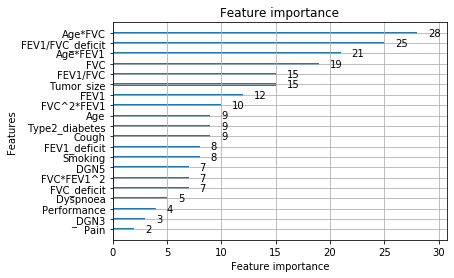

In [5]:
lg_pipe.set_params(**lg_best_params)
print(cross_val_score(lg_pipe, X_train, y_train, cv=kf, scoring='roc_auc').mean())
lg_pipe.fit(X_train.drop(columns=X_train.columns[ign_feats]), y_train)
lgb.plot_importance(lg_pipe.steps[1][1])

In [8]:
lg_trials.vals.keys()

dict_keys(['model__lambda', 'model__learning_rate', 'model__max_depth', 'model__n_estimators', 'model__subsample'])

(array([0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 , 0.475, 0.5  ,
        0.525]),
 <a list of 10 Text yticklabel objects>)

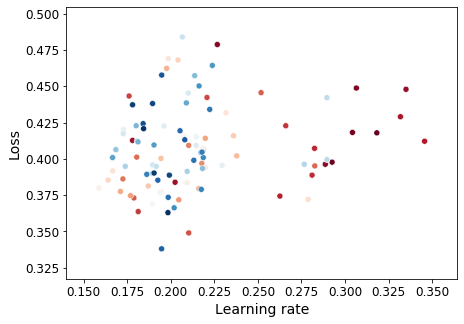

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
param = lg_trials.vals['model__learning_rate']
loss = [x['loss'] for x in lg_trials.results]
fig=plt.figure(figsize=(7,5))
sns.scatterplot(x=param, y=loss, c=range(len(loss)), cmap='RdBu') # Blue = later trials
plt.xlabel("Learning rate", size=14)
plt.ylabel("Loss", size=14)
plt.xticks(size=12)
plt.yticks(size=12)

In [ ]:
ign_feats = list(range(16,18))+list(range(20,24))
X_train.columns[ign_feats]

In [ ]:
list(range(16,18))+[20]+[23]

### Manual bootstrapping minority class